In [1]:
import numpy as np
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from PIL import Image
from io import BytesIO
from trajectory_visualizer import TrajectoryVisualizer

In [2]:
with open("simulated_stroke_data/strokes.npy", "rb") as f:
    strokes = np.load(f)
with open("simulated_stroke_data/trajectories.npy", "rb") as f:
    trajectories = np.load(f)

strokes = torch.from_numpy(strokes).float()
trajectories = torch.from_numpy(trajectories).float()

In [3]:
tv = TrajectoryVisualizer(-1, 1, -1, 1, 0, 1)

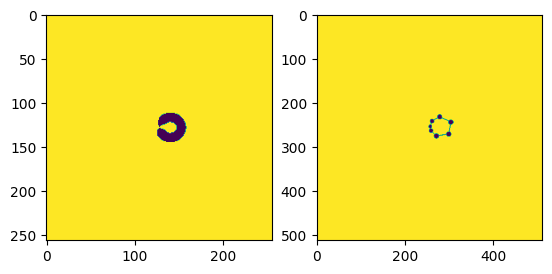

In [4]:
idx = 200
_, axs = plt.subplots(1,2)
axs[0].imshow(strokes[idx])
axs[1].imshow(tv.visualize_trajectory(trajectories[idx]))

In [5]:
from StrokeTrajDataset import StrokeTrajDataset
from SimBetaVAE import SimBetaVAE
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import wandb

wandb.init(project="diverse-strokes")

max_capacity = 2
beta = 0.1
num_epochs = 1000
epochs_per_save = 50

wandb.config = {
    "epochs": num_epochs,
    "beta": beta,
    "max_capacity": max_capacity
}

resize64 = torchvision.transforms.Resize((64, 64), antialias=True)
resize512 = torchvision.transforms.Resize((512, 512), antialias=True)
s = resize64(strokes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

model = SimBetaVAE(beta)
model.to(device)
optimizer = optim.Adam(model.parameters())

train_test_split = int(0.8 * len(s))
from sklearn.utils import shuffle
s, t = shuffle(s, trajectories, random_state=0)
train = s[:train_test_split], t[:train_test_split]
test = s[train_test_split:], t[train_test_split:]

train_dataset = StrokeTrajDataset(*train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = StrokeTrajDataset(*test)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def validation(model, dataloader, capacity):
    model.eval()
    total_loss = 0
    originals = []
    decoder_outputs = []
    
    for (stroke,trajectory) in dataloader:
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args, capacity)
        total_loss += loss * batch_size
        
        for i in range(batch_size):
            stroke_dec = args[0][0][i].squeeze(0).cpu().detach()
            traj_dec = args[0][1][i].cpu().detach()
            decoder_outputs.append((stroke_dec, traj_dec))
            stroke = args[1][0][i].squeeze(0).cpu().detach()
            traj = args[1][1][i].cpu().detach()
            originals.append((stroke, traj))

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, decoder_outputs, originals

for epoch in range(num_epochs):
    capacity = epoch / num_epochs * max_capacity
    total_loss = 0
    wandb.log({'epoch': epoch, 'capacity': capacity})
    for (i, (stroke, trajectory)) in enumerate(train_dataloader):
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args, capacity)
        
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0 and epoch%epochs_per_save == epochs_per_save-1:
            output_dir = f"training_outputs/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                stroke_dec = args[0][0][i].squeeze(0).cpu().detach()
                stroke_dec_img = resize512(stroke_dec.unsqueeze(0).unsqueeze(0))
                traj_dec = args[0][1][i].cpu().detach()
                traj_dec_img = tv.visualize_trajectory(traj_dec).float()
                stroke = args[1][0][i].squeeze(0).cpu().detach()
                stroke_img = resize512(stroke.unsqueeze(0).unsqueeze(0))
                traj = args[1][1][i].cpu().detach()
                traj_img =  tv.visualize_trajectory(traj).float()

                images = [
                    wandb.Image(stroke_dec_img, caption='decoded stroke intensities'),
                    wandb.Image(stroke_img, caption='original stroke intensities'),
                    wandb.Image(traj_dec_img, caption='decoded trajectory'),
                    wandb.Image(traj_img, caption='original trajectory')
                ]
                wandb.log({"training outputs": images})
                # plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
                # plt.imsave(f"{output_dir}/{i}-original.png", stroke)
                # plt.imsave(f"{output_dir}/{i}-traj_decoded.png", tv.visualize_trajectory(traj_dec))
                # plt.imsave(f"{output_dir}/{i}-traj_original.png", tv.visualize_trajectory(traj))
    
    train_loss = total_loss / len(train_dataset)
    val_loss, decoded_list, original_list = validation(model, val_dataloader, capacity)
    wandb.log({
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    if epoch%epochs_per_save == epochs_per_save-1:
        output_dir = f"training_outputs/epoch{epoch}/val"
        os.makedirs(output_dir, exist_ok=True)
        for i in range(len(decoded_list)):
            stroke_dec, traj_dec = decoded_list[i][0], decoded_list[i][1]
            stroke, traj = original_list[i][0], original_list[i][1]
            stroke_dec_img = resize512(stroke_dec.unsqueeze(0).unsqueeze(0))
            traj_dec_img = tv.visualize_trajectory(traj_dec).float()
            stroke_img = resize512(stroke.unsqueeze(0).unsqueeze(0))
            traj_img =  tv.visualize_trajectory(traj).float()

            images = [
                wandb.Image(stroke_dec_img, caption='decoded stroke intensities'),
                wandb.Image(stroke_img, caption='original stroke intensities'),
                wandb.Image(traj_dec_img, caption='decoded trajectory'),
                wandb.Image(traj_img, caption='original trajectory')
            ]
            wandb.log({"validation outputs": images})
            # plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
            # plt.imsave(f"{output_dir}/{i}-original.png", stroke)
            # plt.imsave(f"{output_dir}/{i}-traj_decoded.png", tv.visualize_trajectory(traj_dec))
            # plt.imsave(f"{output_dir}/{i}-traj_original.png", tv.visualize_trajectory(traj))
    print(f"Epoch {epoch}: Train loss={train_loss}, Validation loss={val_loss}")

wandb: Currently logged in as: whalevomit. Use `wandb login --relogin` to force relogin


Epoch 0: Train loss=1.2198961973190308, Validation loss=1.0027345418930054
Epoch 1: Train loss=0.3402586877346039, Validation loss=0.2693100571632385
Epoch 2: Train loss=0.185883030295372, Validation loss=0.14574399590492249
Epoch 3: Train loss=0.13893626630306244, Validation loss=0.11506839841604233
Epoch 4: Train loss=0.1178288385272026, Validation loss=0.10189733654260635
Epoch 5: Train loss=0.10686611384153366, Validation loss=0.08858727663755417
Epoch 6: Train loss=0.09809824824333191, Validation loss=0.07965292781591415
Epoch 7: Train loss=0.09602067619562149, Validation loss=0.08233075588941574
Epoch 8: Train loss=0.09073503315448761, Validation loss=0.0799046978354454
Epoch 9: Train loss=0.08982979506254196, Validation loss=0.0821818932890892
Epoch 10: Train loss=0.09016872197389603, Validation loss=0.08075857907533646
Epoch 11: Train loss=0.08628007769584656, Validation loss=0.07710671424865723
Epoch 12: Train loss=0.08741794526576996, Validation loss=0.07914508879184723
Epoch

wandb: Network error resolved after 0:00:01.167605, resuming normal operation.


Epoch 553: Train loss=0.0254194475710392, Validation loss=0.043310754001140594
Epoch 554: Train loss=0.026575515046715736, Validation loss=0.03970925137400627
Epoch 555: Train loss=0.02642242982983589, Validation loss=0.04710644111037254
Epoch 556: Train loss=0.025655824691057205, Validation loss=0.03760906681418419
Epoch 557: Train loss=0.025609362870454788, Validation loss=0.03423553332686424
Epoch 558: Train loss=0.023699479177594185, Validation loss=0.03345348313450813
Epoch 559: Train loss=0.025468433275818825, Validation loss=0.03278481215238571
Epoch 560: Train loss=0.02486189641058445, Validation loss=0.031818825751543045
Epoch 561: Train loss=0.02361418679356575, Validation loss=0.02690739929676056
Epoch 562: Train loss=0.024436265230178833, Validation loss=0.04021814092993736
Epoch 563: Train loss=0.021544519811868668, Validation loss=0.03305429965257645
Epoch 564: Train loss=0.022183816879987717, Validation loss=0.040227193385362625
Epoch 565: Train loss=0.02513330988585949,

wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request


Epoch 609: Train loss=0.022685987874865532, Validation loss=0.02526627480983734
Epoch 610: Train loss=0.021234197542071342, Validation loss=0.02983849123120308
Epoch 611: Train loss=0.022841155529022217, Validation loss=0.03582184389233589
Epoch 612: Train loss=0.02119307965040207, Validation loss=0.032752860337495804
Epoch 613: Train loss=0.022097503766417503, Validation loss=0.032147109508514404
Epoch 614: Train loss=0.021152973175048828, Validation loss=0.028675084933638573
Epoch 615: Train loss=0.0229345690459013, Validation loss=0.02906683087348938
Epoch 616: Train loss=0.023816443979740143, Validation loss=0.028702152892947197
Epoch 617: Train loss=0.020554689690470695, Validation loss=0.02056337706744671
Epoch 618: Train loss=0.023121489211916924, Validation loss=0.02220478281378746
Epoch 619: Train loss=0.023691460490226746, Validation loss=0.03475388512015343
Epoch 620: Train loss=0.020830189809203148, Validation loss=0.02455318532884121
Epoch 621: Train loss=0.022873695939779

wandb: Network error resolved after 0:00:07.823925, resuming normal operation.


Epoch 783: Train loss=0.016973044723272324, Validation loss=0.027236534282565117
Epoch 784: Train loss=0.016108643263578415, Validation loss=0.02234807424247265
Epoch 785: Train loss=0.015784285962581635, Validation loss=0.02648753486573696
Epoch 786: Train loss=0.017440328374505043, Validation loss=0.02755235694348812
Epoch 787: Train loss=0.017919592559337616, Validation loss=0.028139447793364525
Epoch 788: Train loss=0.016316449269652367, Validation loss=0.03939695283770561
Epoch 789: Train loss=0.017186714336276054, Validation loss=0.027414290234446526
Epoch 790: Train loss=0.01620735228061676, Validation loss=0.017766283825039864
Epoch 791: Train loss=0.016391700133681297, Validation loss=0.021977392956614494
Epoch 792: Train loss=0.017705610021948814, Validation loss=0.023241430521011353
Epoch 793: Train loss=0.015545922331511974, Validation loss=0.03429322689771652
Epoch 794: Train loss=0.015780789777636528, Validation loss=0.047519002109766006
Epoch 795: Train loss=0.0178096927

wandb: Network error resolved after 0:00:07.628230, resuming normal operation.


Epoch 999: Train loss=0.013301866129040718, Validation loss=0.016572890803217888


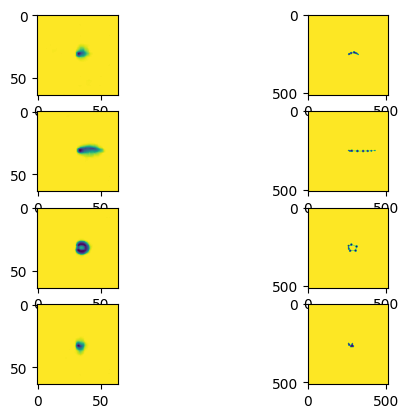

In [6]:
s, t = model.sample_latent(4)
_, axs = plt.subplots(4, 2)
for i in range(4):
    axs[i][0].imshow(s[i].squeeze(0).cpu().detach())
    axs[i][1].imshow(tv.visualize_trajectory(t[i].cpu().detach()))

In [7]:
def no_gap_plot(data): # https://stackoverflow.com/questions/42675864/how-to-remove-gaps-between-image-subplots
    # data: N x M x individual image
    N = len(data)
    M = len(data[0])
    heights = [50 for a in data]
    widths = [50 for a in data[0]]
    
    fig_width = 8.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(N,M, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})

    for i in range(N):
        for j in range(M):
            axarr[i, j].imshow(data[i][j])
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

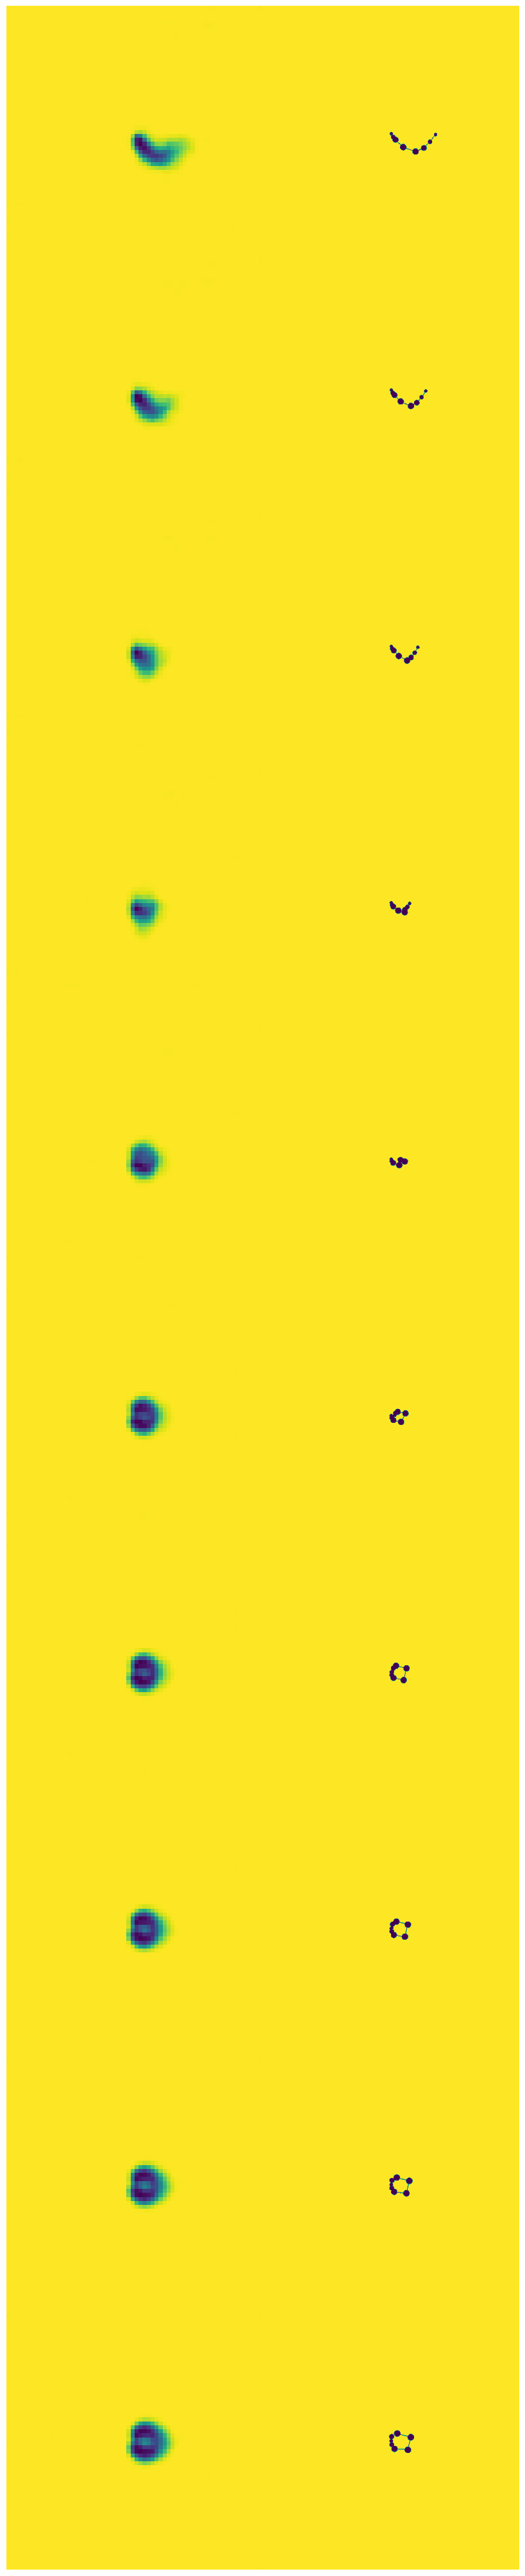

In [8]:
# Interpolating between strokes
def interpolate(idx0, idx1):
    s = resize64(strokes)
    t = trajectories
    s0 = s[idx0].unsqueeze(0).unsqueeze(0).to(device)
    t0 = t[idx0].unsqueeze(0).to(device)
    s1 = s[idx1].unsqueeze(0).unsqueeze(0).to(device)
    t1 = t[idx1].unsqueeze(0).to(device)
    enc0, _ = model.encode(s0, t0)
    enc1, _ = model.encode(s1, t1)
    
    num_images = 10
    data = []
    for i in range(num_images):
        t = i / (num_images - 1)
        enc = enc0*(1-t) + enc1*t
        stroke, trajectory = model.decode(enc)
        stroke = stroke.cpu().detach().reshape((64, 64))
        trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
        data.append([stroke, trajectory])
    no_gap_plot(data)

interpolate(11, 202)

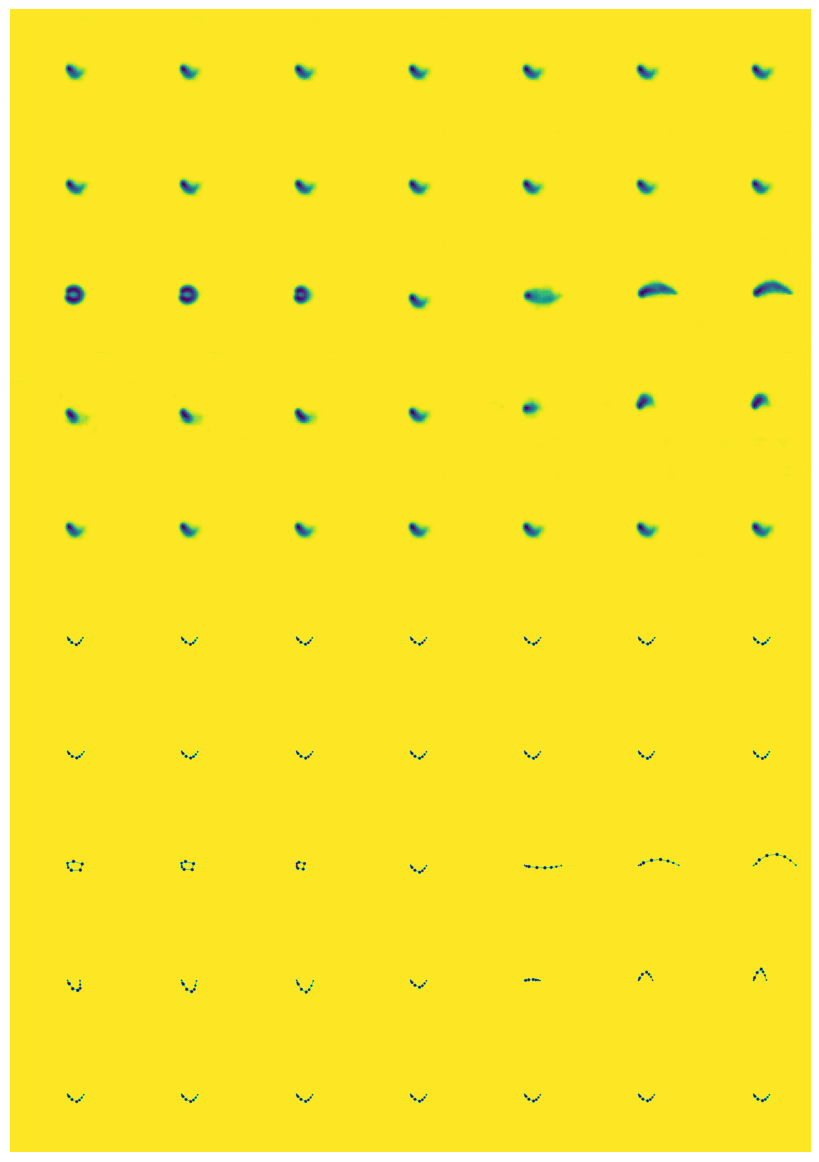

In [9]:
# Varying different latent variables at a time
def vary_one_at_a_time(idx):
    rs = resize64(strokes)
    s = rs[idx].unsqueeze(0).unsqueeze(0).to(device)
    t = trajectories[idx].unsqueeze(0).to(device)
    enc, _ = model.encode(s, t)
    s_data = []
    t_data = []
    for i in range(5):
        s_data_row = []
        t_data_row = []
        for j in range(-3, 4):
            shift = torch.zeros(5)
            shift[i] += j
            shift = shift.to(device)
            shifted = enc + shift
            stroke, trajectory = model.decode(shifted)
            stroke = stroke.cpu().detach().reshape((64, 64))
            trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
            s_data_row.append(stroke)
            t_data_row.append(trajectory)
        s_data.append(s_data_row)
        t_data.append(t_data_row)
    data = s_data + t_data
    no_gap_plot(data)
vary_one_at_a_time(0)